In [2]:
# If you're doing `import gdal` instead,
# you're likely to run into all kinds of low-level library issues
from osgeo import gdal
import matplotlib.pyplot as plt

## GeoTIFF Files

You're likely to get files with `.tif` extension from others using `ArcGIS` or `QGIS`. This is raster data (with some global geometry information). Use `gdal` to read this as a `Dataset`.

In [6]:
# Download a large file, cache and make it available locally.
# This cell will take a long time to run initially, but should be fast
# in subsequent executions.

# We don't want to assume that our package is installed,
# but keep these notebooks as lightweight and portable as possible.
import sys; sys.path.append("../src/deepmap/data")
from ondemand import get_file
tif_filename = get_file("aerial_1970_clipped")

dataset = gdal.Open(tif_filename, gdal.GA_ReadOnly)

Print some useful information about this Dataset.

In [7]:
print("Driver: {}/{}".format(dataset.GetDriver().ShortName, dataset.GetDriver().LongName))
print("Size is {} x {} x {}".format(dataset.RasterXSize,
                                    dataset.RasterYSize,
                                    dataset.RasterCount))
print("Projection is {}".format(dataset.GetProjection()))

Driver: GTiff/GeoTIFF
Size is 23354 x 23550 x 1
Projection is PROJCS["WGS 84 / UTM zone 33S",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",15],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32733"]]


A Dataset has embedded geo-referencing information (of course, otherwise we wouldn't know where to place it on an actual map and it would have limited use).

In [4]:
geotransform = dataset.GetGeoTransform()
if geotransform:
    # Note the weird order of elements in the 6-tuple.
    # See https://gdal.org/tutorials/geotransforms_tut.html for details
    print("Origin = ({}, {})".format(geotransform[0], geotransform[3]))
    print("Pixel Size = ({}, {})".format(geotransform[1], geotransform[5]))

Origin = (568326.2965000002, 8078976.1364)
Pixel Size = (0.9999651836944459, -0.9999758895966293)


A Dataset has raster information (small flattened aerial/satellite images that we can tile and visualize).

In [5]:
# A gdal Dataset has several raster bands, going from 1 to <dataset.RasterCount>
print(f"Total bands = {dataset.RasterCount}")

band = dataset.GetRasterBand(1)
print("Band Type = {}".format(gdal.GetDataTypeName(band.DataType)))

min = band.GetMinimum()
max = band.GetMaximum()
if not min or not max:
    (min, max) = band.ComputeRasterMinMax(True)
print("Band min={:.3f}, Band max={:.3f}".format(min, max))

if band.GetOverviewCount() > 0:
    print("Band has {} overviews".format(band.GetOverviewCount()))

if band.GetRasterColorTable():
    print("Band has a color table with {} entries".format(band.GetRasterColorTable().GetCount()))

Total bands = 1
Band Type = Byte
Band min=55.000, Band max=248.000


We can read the actual data as a numpy array (careful with this for large `.tif` files).

In [6]:
im = band.ReadAsArray()
print("Shape = {}".format(im.shape))
print("Dtype = {}".format(im.dtype))

Shape = (23550, 23354)
Dtype = uint8


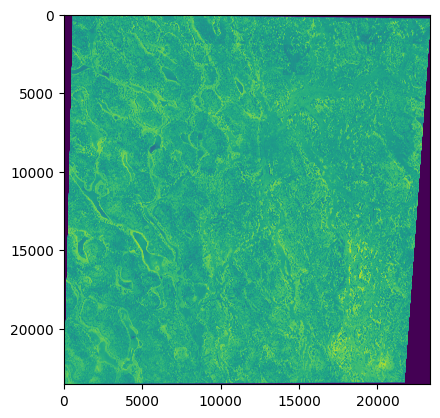

In [7]:
plt.imshow(im)

Now that we know what's inside a `.tiff`, we won't actually be using `gdal`, but `rasterio` (a more convenient Python library that sits on top of `gdal`).